# Customer personal data protection

The goal of a project is to protect the data of the "Hot Flood" insurance company's clients by developing a data transformation method that makes it difficult to recover personal information from it. The correctness of its operation needs to be justified.

The goal is to protect the data in such a way that the quality of machine learning models does not deteriorate during the transformation. There is no need to select the best model.

The project consists of a few parts:

 1) Preliminary checking the data
 2) Checking mathematically, if the data can be transformed through the reversible martix
 3) Checking the quality of the linear regression with trasformed data (R2 metric should be evaluated)

## Preliminary data analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/mojseenkodenis/Desktop/insurance.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
#The data is in Russian, so let's change the column names to English
data = data.rename(columns={'Пол': 'Gender', 
                     'Возраст': 'Age', 
                     'Зарплата': 'Salary', 
                     'Члены семьи': 'Family members', 
                     'Страховые выплаты': 'Insurance payments'})

In [5]:
data.head()

,Gender,Age,Salary,Family members,Insurance payments
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [6]:
data.describe()

,Gender,Age,Salary,Family members,Insurance payments
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


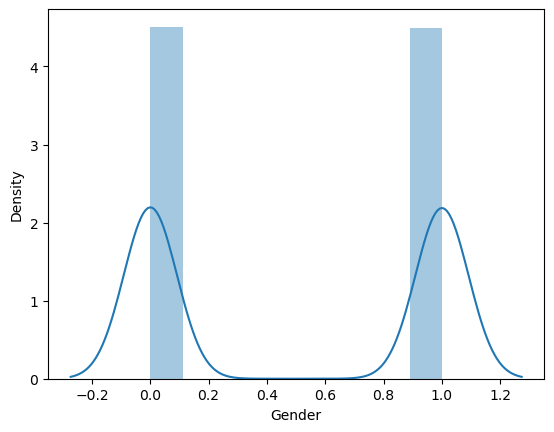

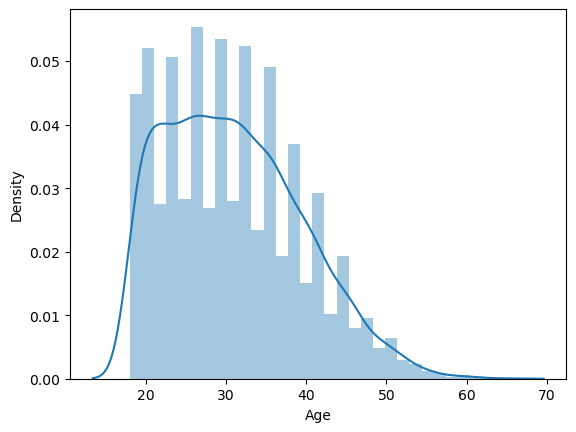

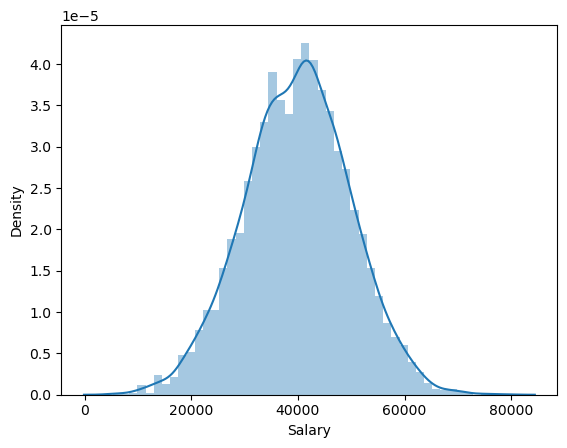

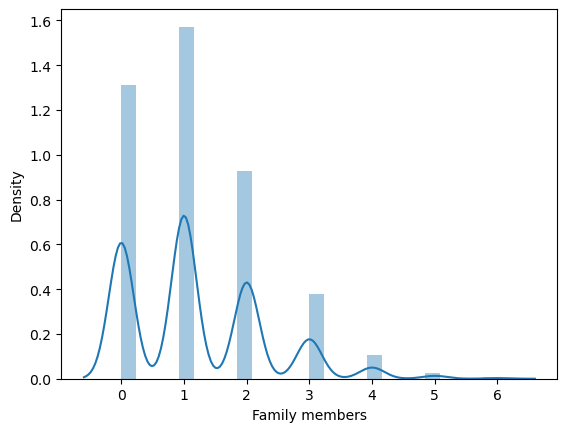

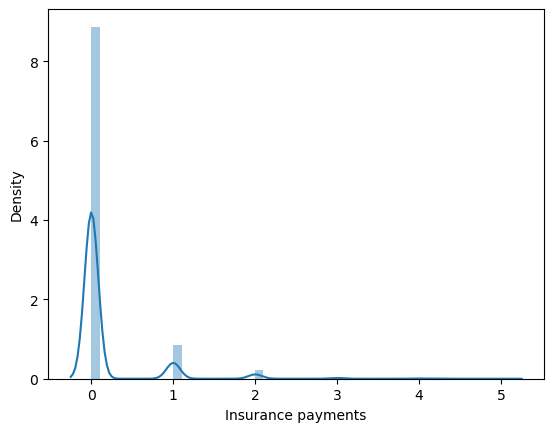

In [7]:
#Cheching the distribution of the features
for i, col in enumerate(data.columns):
    sns.distplot(data[col], kde=True)
    plt.show()

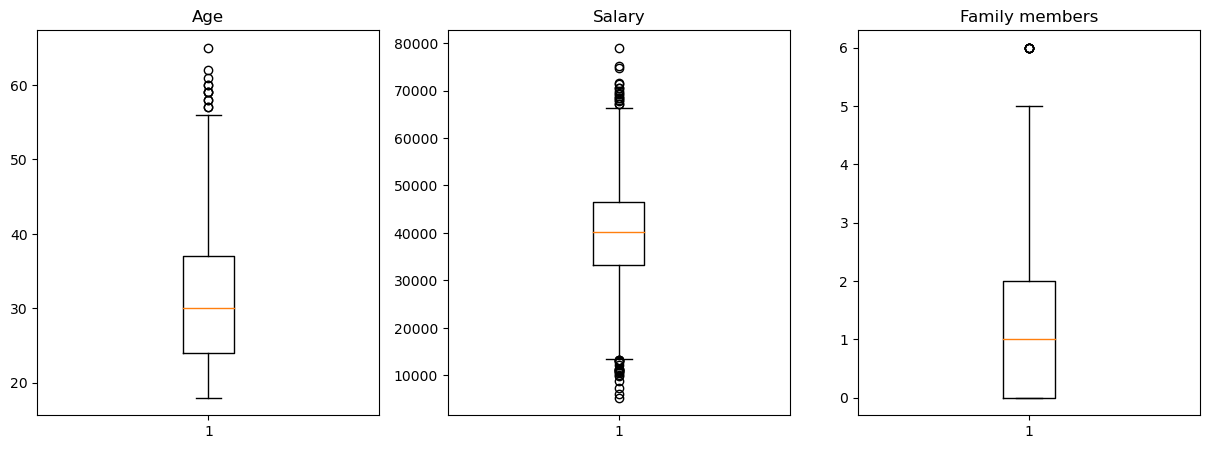

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

columns_to_plot = ['Age', 'Salary', 'Family members']

for i, col in enumerate(columns_to_plot):
    axes[i].boxplot(data[col])
    axes[i].set_title(col)

plt.show()

interval columns not set, guessing: ['Gender', 'Age', 'Salary', 'Family members', 'Insurance payments']


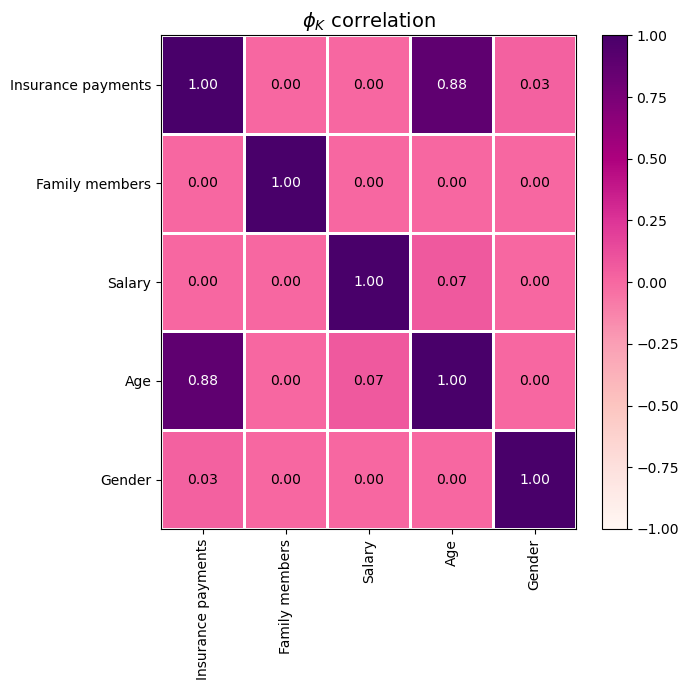

In [9]:
#Checking the correlation between the features
phik_correlation = data.phik_matrix()
plot_correlation_matrix(phik_correlation.values,
                        x_labels=phik_correlation.columns,
                        y_labels=phik_correlation.index,
                        title='$\phi_K$ correlation',
                        figsize=(7, 7),
                        color_map='RdPu')

In the data provided, there are 5 columns: insurance payments will be the target feature, and the remaining columns will be the features. There are 5000 rows in the data, and there are no missing values.

Exploratory data analysis showed that the quantitative features have a normal distribution with outliers, and there is only a correlation between insurance payouts and age (0.88).

## Multiplying matrixes

Notation:

$X$ — feature matrix (the zeroth column consists of ones)

$y$ — target feature vector

$P$ — matrix by which the features are multiplied

$w$ — linear regression weights vector (the zeroth element is the bias)

Predictions:

$$
a = Xw
$$

Learning goal:

$$
w = \arg\min_w MSE(Xw, y)
$$

Learning formula:

$$
w = (X^T X)^{-1} X^T y
$$

Proof:

$$
a' = (XP)w'
$$

$$
a' = XP((XP)^T XP)^{-1} (XP)^T y = XP(P^TX^TXP)^{-1}P^TX^Ty = XPP^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty = X(X^TX)^{-1}X^Ty = Xw = a
$$

**Answer**: R2 won't change.

**Justification**: A linear function has a constant scale of return, so changing the features will not lead to a significant change in prediction accuracy.

## Data transformation algorithm

**Algorithm**:

 1) Create a matrix with random numbers

 2) Verify that it is invertible

 3) Multiply the features by 200

 4) Then subtract 50

 5) Finally, multiply the features by a random matrix

 6) Train linear regression on the original and encrypted data

 7) Compare the R2 metrics obtained

**Justification**

All operations with matrices will alter the original information in a way that will make it difficult to reconstruct without knowing all the steps of the algorithm.

## Algotithm testing

In [10]:
#Checking the accuracy of the model on the original data
target = data['Insurance payments']
features = data.drop('Insurance payments', axis=1)

In [11]:
display(target.shape)
features.shape

(5000,)

(5000, 4)

In [12]:
model = LinearRegression()
model.fit(features, target)
r2 = model.score(features, target)
print(r2)

0.42494550286668


After training the linear regression model on the original data before transformations, the accuracy is 0.424.

Now let's look at the accuracy of the model when we change the features by multiplying them by a matrix.

In [13]:
#Creating 4х4 matrix
MATRIX = np.random.rand(4,4)

#Let's check if it is invertible
np.linalg.inv(MATRIX)

array([[ 2.40514678, -0.68610635, -2.84249617, -0.05385905],
       [ 0.61493912, -2.35822276,  0.23265238,  1.16171512],
       [-2.06090736,  3.7642606 ,  4.17296661, -1.90024494],
       [-1.25889595,  1.46813848, -0.21447954,  0.95782731]])

In [14]:
new_features = features.dot(MATRIX)

In [15]:
model = LinearRegression()
model.fit(new_features, target)
r2 = model.score(new_features, target)
print(r2)

0.4249455028666709


As expected, when multiplying the features by the inverse matrix, the accuracy of the model did not change significantly.

In the end, let's encode the data using the algorithm and check the accuracy of the model with this encoded data.

In [16]:
NEW_MATRIX = np.random.rand(4,4)

np.linalg.inv(NEW_MATRIX)

array([[ 0.03804153, -1.81242054, -1.0250245 ,  1.50060968],
       [ 2.58555999, -1.03660667,  1.00802644, -1.49775709],
       [ 0.61228743, -1.61296011,  1.54768572, -0.32653915],
       [-3.56939688,  5.89048613, -1.7554568 ,  1.81662469]])

In [17]:
algorith_features = (features * 200 - 50) @ NEW_MATRIX

In [18]:
algorith_features.head()

,0,1,2,3
0,295195.785471,1.762403e+06,8.577620e+06,2.751122e+06
1,226238.915429,1.351146e+06,6.571882e+06,2.108481e+06
2,124949.862164,7.468400e+05,3.631788e+06,1.165323e+06
3,248148.886195,1.480724e+06,7.211259e+06,2.312254e+06
4,155325.446425,9.278217e+05,4.513662e+06,1.447963e+06


In [19]:
model = LinearRegression()
model.fit(algorith_features, target)
r2 = model.score(algorith_features, target)
print(r2)

0.42494550286668764


The algorithm verification shows that the model's accuracy after data transformation remains the same as before the transformation or after multiplying only by the matrix (0.424).

Let's try to decrypt the data in the reverse order of the algorithm.

In [20]:
INVERSE_MATRIX = np.linalg.inv(NEW_MATRIX)

decoded_features = (algorith_features @ INVERSE_MATRIX + 50) / 200

In [21]:
decoded_features.head()

,0,1,2,3
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,3.367298e-12,46.0,38000.0,1.000000e+00
2,5.292833e-12,29.0,21000.0,-1.528271e-12
3,6.825545e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,2.217497e-12


In [22]:
features.head()

,Gender,Age,Salary,Family members
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0


If we repeat the algorithm in reverse order, we can recover the original numerical values.

## Conclusion

The goal was to develop a method for protecting customer data for an insurance company. The research showed that data can be multiplied by non-reversible matrices and other mathematical operations can be performed on them to make it difficult to recover the original data.

The accuracy of linear regression trained on both the original and transformed data was 0.424. Thus, the encrypted data can also be used for machine learning model training without losing accuracy.

In the end, the encrypted data was decoded using the reverse algorithm to recover the original information.